In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/data/str_images_symmetric_copy.zip -d /content/

**Import libraries**

In [ ]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [ ]:
# Define parameters and constants
data_dir = "/content/str_images_symmetric_copy"
batch_size = 32
num_classes = 2
num_epochs = 20
learning_rate = 0.0001
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data preparation**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to match MobileNet's input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

# Create DataLoader instances for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number images training: {len(train_dataset)}")
print(f"Number images validation: {len(val_dataset)}")
print(f"Number images test: {len(test_dataset)}")

Number images training: 9600
Number images validation: 2400
Number images test: 3000


In [ ]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
class_names = [v for v in class_to_idx.keys()]

print(class_names)
print("Class to Index Mapping:", class_to_idx)

['fraud', 'origins']
Class to Index Mapping: {'fraud': 0, 'origins': 1}


# Define model

In [ ]:
# Load the pretrained model
model = models.mobilenet_v2(pretrained=True)
# Freeze the feature extractor
for param in model.features.parameters():
  param.requires_grad = False

model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

print(model.classifier)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 135MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 2226434
Trainable parameters: 2562


**Test unfreeze layers**

In [ ]:
layers = list(model.features.children())
print(len(layers))
for layer in layers[-1:]:
  for param in layer.parameters():
    param.requires_grad = True

19


In [ ]:
total_params = sum(p.numel() for p in model.parameters())

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 2226434
Trainable parameters: 414722


# Training model

In [ ]:
#  Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    return epoch_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation during validation
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate running loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    accuracy = correct / total * 100
    return epoch_loss, accuracy

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, save_dir="best_model"):
    best_val_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    os.makedirs(save_dir, exist_ok=True)  # Make sure the directory exists

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print("Best model saved!")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/20


100%|██████████| 75/75 [00:06<00:00, 11.36it/s]


Epoch 1/20, Train Loss: 0.5198, Train Acc: 75.01%, Val Loss: 0.4191, Val Acc: 83.62%
Best model saved!
Epoch 2/20


100%|██████████| 75/75 [00:05<00:00, 13.11it/s]


Epoch 2/20, Train Loss: 0.3854, Train Acc: 83.92%, Val Loss: 0.3707, Val Acc: 84.96%
Best model saved!
Epoch 3/20


100%|██████████| 75/75 [00:05<00:00, 13.09it/s]


Epoch 3/20, Train Loss: 0.3510, Train Acc: 85.28%, Val Loss: 0.3451, Val Acc: 86.08%
Best model saved!
Epoch 4/20


100%|██████████| 75/75 [00:06<00:00, 11.79it/s]


Epoch 4/20, Train Loss: 0.3367, Train Acc: 85.88%, Val Loss: 0.3279, Val Acc: 85.92%
Epoch 5/20


100%|██████████| 75/75 [00:06<00:00, 11.97it/s]


Epoch 5/20, Train Loss: 0.3247, Train Acc: 85.90%, Val Loss: 0.3178, Val Acc: 86.42%
Best model saved!
Epoch 6/20


100%|██████████| 75/75 [00:05<00:00, 13.28it/s]


Epoch 6/20, Train Loss: 0.3154, Train Acc: 86.71%, Val Loss: 0.3163, Val Acc: 85.62%
Epoch 7/20


100%|██████████| 75/75 [00:05<00:00, 13.03it/s]


Epoch 7/20, Train Loss: 0.3092, Train Acc: 86.85%, Val Loss: 0.3037, Val Acc: 87.42%
Best model saved!
Epoch 8/20


100%|██████████| 75/75 [00:06<00:00, 11.59it/s]


Epoch 8/20, Train Loss: 0.3096, Train Acc: 87.12%, Val Loss: 0.2961, Val Acc: 87.08%
Epoch 9/20


100%|██████████| 75/75 [00:06<00:00, 12.17it/s]


Epoch 9/20, Train Loss: 0.3061, Train Acc: 86.93%, Val Loss: 0.3164, Val Acc: 84.62%
Epoch 10/20


100%|██████████| 75/75 [00:05<00:00, 13.30it/s]


Epoch 10/20, Train Loss: 0.3012, Train Acc: 87.17%, Val Loss: 0.2993, Val Acc: 87.38%
Epoch 11/20


100%|██████████| 75/75 [00:05<00:00, 13.13it/s]


Epoch 11/20, Train Loss: 0.3020, Train Acc: 87.23%, Val Loss: 0.3012, Val Acc: 87.12%
Epoch 12/20


100%|██████████| 75/75 [00:06<00:00, 11.73it/s]


Epoch 12/20, Train Loss: 0.2982, Train Acc: 87.50%, Val Loss: 0.2941, Val Acc: 87.12%
Epoch 13/20


100%|██████████| 75/75 [00:06<00:00, 11.78it/s]


Epoch 13/20, Train Loss: 0.2974, Train Acc: 87.54%, Val Loss: 0.2976, Val Acc: 86.00%
Epoch 14/20


100%|██████████| 75/75 [00:05<00:00, 12.88it/s]


Epoch 14/20, Train Loss: 0.3006, Train Acc: 87.24%, Val Loss: 0.3005, Val Acc: 86.50%
Epoch 15/20


100%|██████████| 75/75 [00:05<00:00, 12.76it/s]


Epoch 15/20, Train Loss: 0.2953, Train Acc: 87.46%, Val Loss: 0.2982, Val Acc: 85.62%
Epoch 16/20


100%|██████████| 75/75 [00:06<00:00, 11.66it/s]


Epoch 16/20, Train Loss: 0.2908, Train Acc: 87.45%, Val Loss: 0.2911, Val Acc: 86.79%
Epoch 17/20


100%|██████████| 75/75 [00:06<00:00, 12.45it/s]


Epoch 17/20, Train Loss: 0.2951, Train Acc: 87.02%, Val Loss: 0.2851, Val Acc: 88.50%
Best model saved!
Epoch 18/20


100%|██████████| 75/75 [00:05<00:00, 13.22it/s]


Epoch 18/20, Train Loss: 0.2915, Train Acc: 87.33%, Val Loss: 0.2873, Val Acc: 87.12%
Epoch 19/20


100%|██████████| 75/75 [00:05<00:00, 12.94it/s]


Epoch 19/20, Train Loss: 0.2849, Train Acc: 88.03%, Val Loss: 0.2914, Val Acc: 87.25%
Epoch 20/20


100%|██████████| 75/75 [00:06<00:00, 11.72it/s]

Epoch 20/20, Train Loss: 0.2872, Train Acc: 87.60%, Val Loss: 0.2961, Val Acc: 85.79%


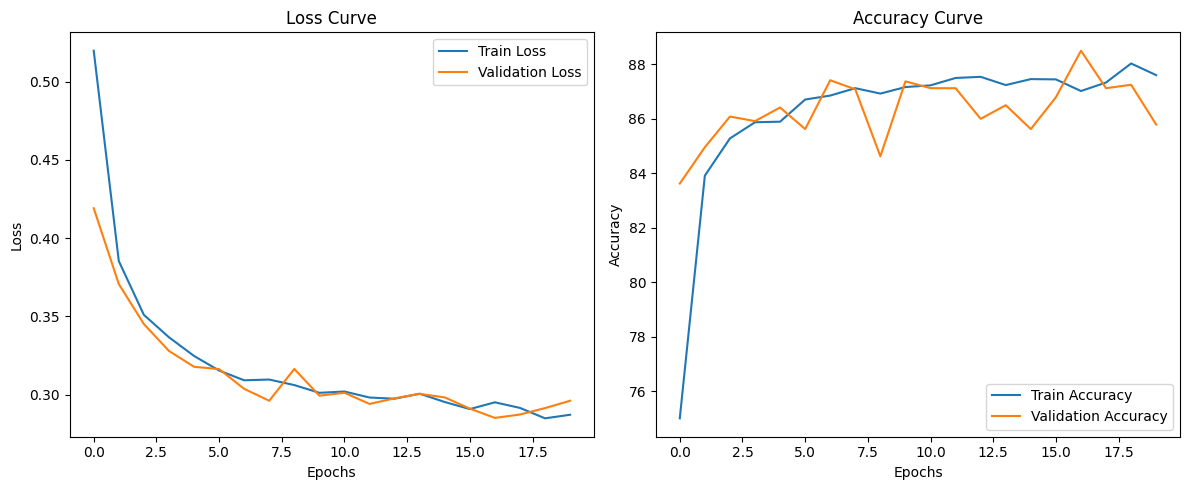

In [ ]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label= 'Train Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction

In [ ]:
# Load saved model
model_path = "/content/best_model/best_model.pth"
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights
model = model.to(device).eval() # Evaluation mode

<ipython-input-14-329826e2f81f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights


In [ ]:
def visualize_predictions(image_paths, model, transform, class_names, device='cuda'):
  """
  Visualizes predictions for 16 images in a 4x4 grid.

  Parameters:
    image_paths: List of 16 image file paths.
    model: The trained model for prediction.
    class_names: List of class names corresponding to the model output indices.
    device: The device to run the model ('cuda' or 'cpu').
  """
  fig, axes = plt.subplots(4, 4, figsize=(8, 8))
  axes = axes.flatten()  # Flatten the 2D axes array for easy indexing

  for idx, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_image)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Softmax for probabilities
      predicted_class_idx = torch.argmax(probabilities).item()  # Get the index of the highest probability
      predicted_label = class_names[predicted_class_idx]  # Map to class label
      confidence = probabilities[predicted_class_idx].item()

    # Display the image with prediction
    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(f"Pred: {predicted_label}\nConf: {confidence:.2f}", fontsize=12, color='blue')

  # Hide any remaining axes (if fewer images are provided)
  for idx in range(len(image_paths), len(axes)):
    axes[idx].axis('off')

  plt.tight_layout()
  plt.show()

['/content/str_images_symmetric_copy/test/origins/psp10_01_02_str_0033_912_1122.jpg', '/content/str_images_symmetric_copy/test/origins/psp06_02_03_str_0018_484_1729.jpg', '/content/str_images_symmetric_copy/test/origins/psp07_01_03_str_0041_1108_546.jpg', '/content/str_images_symmetric_copy/test/origins/psp06_02_01_str_0005_493_1730.jpg', '/content/str_images_symmetric_copy/test/origins/psp05_05_02_str_0028_265_1668.jpg', '/content/str_images_symmetric_copy/test/origins/psp04_03_01_str_0015_283_1627.jpg', '/content/str_images_symmetric_copy/test/origins/psp07_01_02_str_0024_790_554.jpg', '/content/str_images_symmetric_copy/test/origins/psp03_01_03_str_0025_1011_872.jpg', '/content/str_images_symmetric_copy/test/origins/psp01_02_01_str_0015_563_1501.jpg', '/content/str_images_symmetric_copy/test/origins/psp07_01_01_str_0011_651_1300.jpg', '/content/str_images_symmetric_copy/test/origins/psp09_04_03_str_0031_443_1726.jpg', '/content/str_images_symmetric_copy/test/origins/psp10_01_02_str_

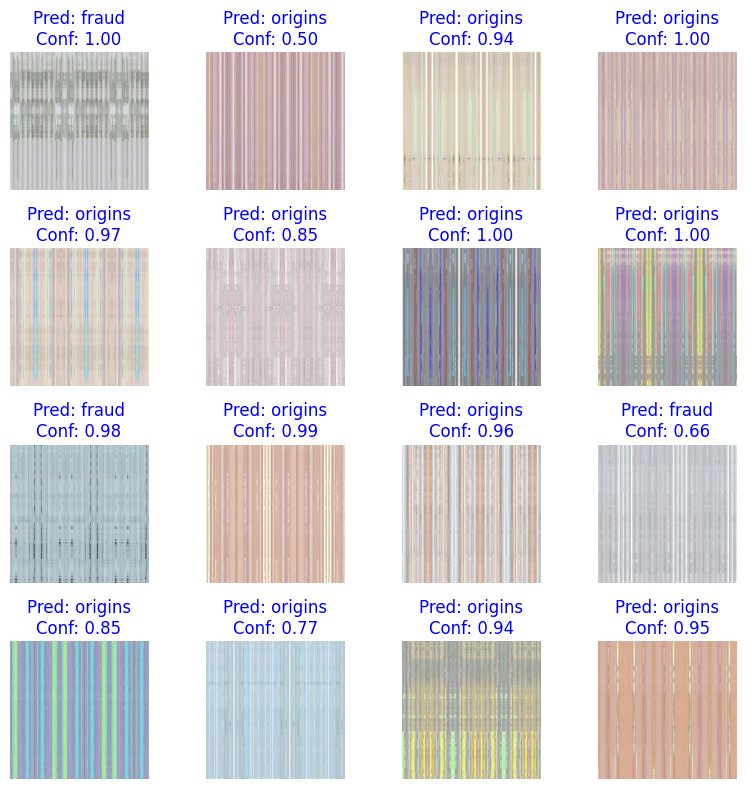

In [ ]:
test_folder = '/content/str_images_symmetric_copy/test/origins'
image_paths = os.listdir(test_folder)
test_image_paths = [os.path.join(test_folder, path) for path in image_paths][:16]

print(test_image_paths)
visualize_predictions(test_image_paths, model, transform, class_names, device)


# Evaluation

In [ ]:
!unzip /content/psp01_02_01_jpg.zip -d /content

Archive:  /content/psp01_02_01_jpg.zip
   creating: /content/psp01_02_01_jpg/
  inflating: /content/psp01_02_01_jpg/str_0000_2135_4400.jpg  
  inflating: /content/psp01_02_01_jpg/str_0001_798_218.jpg  
  inflating: /content/psp01_02_01_jpg/str_0002_2805_2175.jpg  
  inflating: /content/psp01_02_01_jpg/str_0003_1397_821.jpg  
  inflating: /content/psp01_02_01_jpg/str_0004_2632_2466.jpg  
  inflating: /content/psp01_02_01_jpg/str_0005_1393_2061.jpg  
  inflating: /content/psp01_02_01_jpg/str_0006_739_609.jpg  
  inflating: /content/psp01_02_01_jpg/str_0007_1259_1025.jpg  
  inflating: /content/psp01_02_01_jpg/str_0008_2289_2795.jpg  
  inflating: /content/psp01_02_01_jpg/str_0009_2115_949.jpg  
  inflating: /content/psp01_02_01_jpg/str_0010_2224_4422.jpg  
  inflating: /content/psp01_02_01_jpg/str_0011_370_4294.jpg  
  inflating: /content/psp01_02_01_jpg/str_0012_251_3971.jpg  
  inflating: /content/psp01_02_01_jpg/str_0013_1101_206.jpg  
  inflating: /content/psp01_02_01_jpg/str_0014_21

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to match MobileNet's input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load saved model
model_path = "/content/best_model/best_model.pth"
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights
model = model.to(device).eval() # Evaluation mode

<ipython-input-17-85c7f672eb58>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights


In [ ]:
test_dir = "/content/str_images_symmetric_copy/test/fraud"
images = os.listdir(test_dir)
image_paths = [os.path.join(test_dir, img) for img in images if img.endswith(('.jpg', '.png'))]
count_origins = 0
count_fraud = 0
for idx, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_image)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Softmax for probabilities
      predicted_class_idx = torch.argmax(probabilities).item()  # Get the index of the highest probability
      predicted_label = class_names[predicted_class_idx]  # Map to class label
      # print(predicted_label)
      if predicted_label == 'origins':
        count_origins += 1
      else:
        count_fraud += 1
      confidence = probabilities[predicted_class_idx].item()

print("Number random path original : ", count_origins)
print("Number random path fraud : ", count_fraud)

Number random path original :  221
Number random path fraud :  1279


**Create Confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(model, data_loader, class_names=("fraud", "origins")):
    """
    Evaluates the model on the validation set and creates a confusion matrix.

    Parameters:
        model: Trained model to evaluate.
        validation_loader: DataLoader for the validation set.
        class_names: Names of the classes (default: "fraud" and "origins").

    Returns:
        cm: The confusion matrix as a NumPy array.
    """
    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in data_loader:
            # Move inputs and labels to the appropriate device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert outputs to predicted classes
            _, preds = torch.max(outputs, 1)

            # Collect predictions and ground truth
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #############################################

    # Normalize the confusion matrix to percentages
    cm_percentage = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    # Display the confusion matrix with percentages
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.colorbar(im, ax=ax)

    # Add text annotations (percentages and raw counts)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percentage[i, j]:.2f}%\n({cm[i, j]})",
                    ha="center", va="center",
                    color="white" if cm_percentage[i, j] > 50 else "black")

    # Add labels, title, and axes
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return cm

    # # Display the confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    # disp.plot(cmap=plt.cm.Blues, values_format='d')
    # plt.title("Confusion Matrix")
    # plt.show()

    # return cm


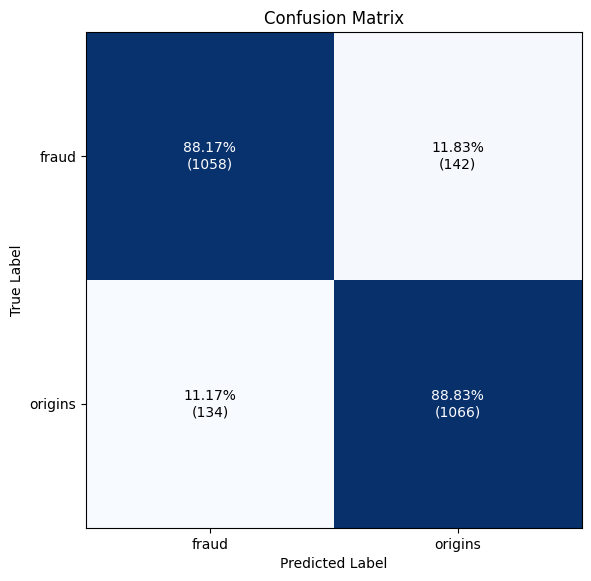

Confusion Matrix:
 [[1058  142]
 [ 134 1066]]


In [ ]:
cm = create_confusion_matrix(model, val_loader, class_names=["fraud", "origins"])
print("Confusion Matrix:\n", cm)

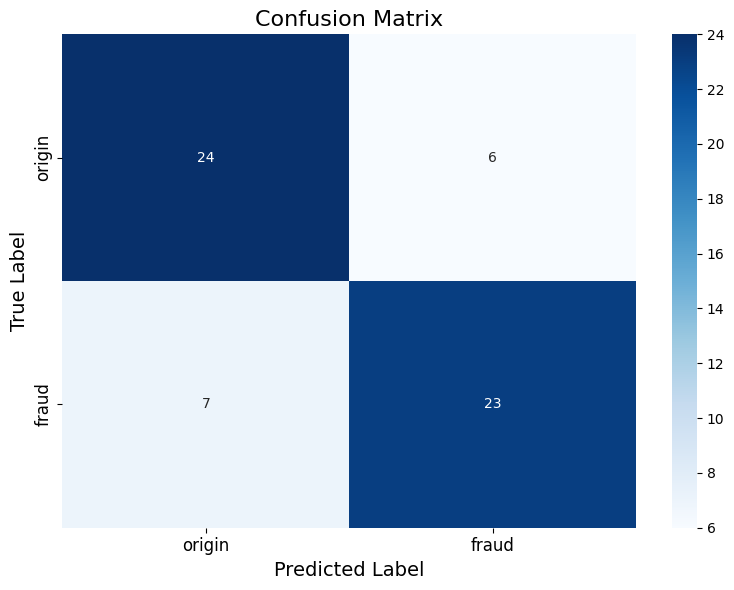

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = np.array([[24, 6],  # [TP, FN]
                             [7, 23]])  # [FP, TN]

# Class labels
classes = ["origin", "fraud"]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

# Add labels, title, and axes ticks
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()